In [2]:
import torch
import torch_geometric
import os
from glob import glob
import json
from torch_geometric.nn import radius, knn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from torch_geometric.nn.pool import knn
from torch_geometric.data import Data
from torch_geometric.utils import k_hop_subgraph, to_undirected, subgraph
import random
from torch_geometric.data import Batch
from copy import deepcopy
from torch_geometric.nn.pool import knn_graph, radius_graph
import importlib
from importlib import reload
import math
import sys
import time
import networkx as nx
import torch.nn.functional as F
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap.umap_ as umap


%matplotlib notebook
%matplotlib inline

In [3]:
script_path = "/xdisk/twheeler/jgaiser/ContrastVS/contrast_vs/src/"

if script_path not in sys.path:
    sys.path.append(script_path)
    
original_cwd = os.getcwd()
os.chdir(script_path)

import utils
importlib.reload(utils)

import pdb_utils 
importlib.reload(pdb_utils)

import app_utils 
importlib.reload(app_utils)

from pdb_utils import vox_onehot
from app_utils import load_models

os.chdir(original_cwd)

In [4]:
# ---- Get union of 50 closest protein atoms per ligand atom
# ---- Store results for convenience

def trim_protein_graph(pg, mg, n_closest=50):
    '''
    Trims protein graph nodes so that only the n_closest to any mol atom is saved.
    For saving space and time.
    '''
    prox_prot_atoms = torch.unique(knn(pg.pos, mg.pos, n_closest)[1])

    pg.x = pg.x[prox_prot_atoms]
    pg.pos = pg.pos[prox_prot_atoms]
    
    return pg

def get_trimmed_pairs(pg_dir, mg_dir, n_closest=50):
    '''
    Get the trimmed protein and ligand graph pairs for every pdbbind sample.
    
    '''
    protein_graph_files = glob(pg_dir + '/*.pyg')
    mol_graph_files = glob(mg_dir + '/*.pyg')
    pairs = []

    for pg_i, pg_file in enumerate(protein_graph_files):
        pdb_id = pg_file.split('/')[-1].split('_')[0]
        no_mg = True 

        for mg_file in mol_graph_files:
            if pdb_id in mg_file:
                no_mg = False
                break

        if no_mg: continue

        pg = torch.load(pg_file)
        mg = torch.load(mg_file)

        trimmed_pg = trim_protein_graph(pg, mg, n_closest)
        pairs.append((trimmed_pg,mg))

    return pairs 

In [5]:
# protein_graph_dir = '/xdisk/twheeler/jgaiser/ContrastVS/data/pdbbind/protein_graphs/'
# mol_graph_dir = '/xdisk/twheeler/jgaiser/ContrastVS/data/pdbbind/k3_ligand_graphs/'

# PAIRS = get_trimmed_pairs(protein_graph_dir, mol_graph_dir)
    
# random.shuffle(PAIRS)
# torch.save(PAIRS[800:], '/xdisk/twheeler/jgaiser/ContrastVS/data/TRAIN_PAIRS_4-26.pt')
# torch.save(PAIRS[:800], '/xdisk/twheeler/jgaiser/ContrastVS/data/VALIDATION_PAIRS_4-26.pt')

TRAIN_PAIRS = torch.load('/xdisk/twheeler/jgaiser/ContrastVS/data/TRAIN_PAIRS_4-26.pt')
VALIDATION_PAIRS = torch.load('/xdisk/twheeler/jgaiser/ContrastVS/data/VALIDATION_PAIRS_4-26.pt')

In [6]:
def get_proximal_mol_atoms(pg, mg, max_dist=4):
    return torch.unique(radius(pg.pos, mg.pos, max_dist)[0])

def add_voxels(pg, vox_coords):
    pg = deepcopy(pg)
    vox_block = vox_onehot().unsqueeze(0).repeat(vox_coords.size(0),1)
    
    pg.vox_mask = torch.hstack((torch.zeros(pg.pos.size(0)),
                                torch.ones(vox_block.size(0)))).bool()
    
    pg.x = torch.vstack((pg.x, vox_block))
    pg.pos = torch.vstack((pg.pos, vox_coords))
    
    return pg
    
    
def generate_batch(pairs, 
                   vox_temp=0.5, 
                   protein_temp=0.1):
    p_batch = []
    m_batch = []
    
    for pg, mg in pairs:
        mg = deepcopy(mg)
        pg = deepcopy(pg)
         
        mg.prox_mask = torch.zeros(mg.x.size(0)).bool()
        mg.prox_mask[get_proximal_mol_atoms(pg, mg, 4)] = True
        
        vox_pos = mg.pos[mg.prox_mask]  
        
        vox_pos += torch.randn_like(vox_pos)*vox_temp
        pg.pos += torch.randn_like(pg.pos)*protein_temp
        
        pg = add_voxels(pg, vox_pos)
        
        p_batch.append(pg)
        m_batch.append(mg)
        
    return Batch.from_data_list(p_batch), Batch.from_data_list(m_batch)

In [7]:
def scramble_mol_indices(mb):
    scrambled_idx = []
    
    for i in torch.unique(mb.batch):
        neg_atom_pool = torch.where(mb.batch==i)[0]
        scrambled_idx.append(neg_atom_pool[torch.randperm(neg_atom_pool.size(0))])
        
    return(torch.hstack(scrambled_idx))

In [8]:
model_id = '4-25'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_path = '/xdisk/twheeler/jgaiser/ContrastVS/contrast_vs/models/%s/' % model_id

pe_w_path = model_path + 'pe_w_exp.pt'
me_w_path = model_path + 'me_w_exp.pt'

pe, me = load_models(model_path, load_weights=True, weight_suffix='_exp')
# pe, me = load_models(model_path, load_weights=False)

pe = pe.to(device)
me = me.to(device)

In [9]:
def plot_histogram_data(data, bins=20):
    plt.clf()
    r = [x.item() for x in [data.mean()-data.std()*3, data.mean()+data.std()*3]]
    plt.hist(data, bins=bins, range=r, alpha=0.5)
    plt.ylim(top=500)
    plt.show()

In [10]:
def loss_weight(batch_number, phase=0, period=500, magnitude=0.75):
    phase_mod = (period/3.14)*phase
    return (1-abs(torch.sin(torch.tensor((phase_mod + batch_number)/period*3.14)))*magnitude).item()


In [14]:
mol_feature_strings = []


for bi in range(len(VALIDATION_PAIRS) // BATCH_SIZE):
    start_idx = bi*BATCH_SIZE
    stop_idx = start_idx + BATCH_SIZE
    pb,mb = generate_batch(VALIDATION_PAIRS[start_idx:stop_idx], vox_temp=0, protein_temp=0)

    for row in mb.x:
        row_str = ''.join([str(x.item()) for x in row])
        if row_str not in mol_feature_strings:
            mol_feature_strings.append(row_str)
            
mol_feature_strings = sorted(mol_feature_strings)

In [15]:
BATCH_SIZE = 16 

def cos_score(a, p, n):
    cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
    return cos(a,p)-cos(a,n)

def l2_score(a, p, n):
    return torch.norm(a-n, dim=1)-torch.norm(a-p, dim=1)

def combined_score(a,p,n):
    cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
    
    p_cos_d = 1-cos(a,p)
    n_cos_d = 1-cos(a,n)
    
    p_dist = torch.norm(a-p, dim=1)
    n_dist = torch.norm(a-n, dim=1)
    
    return n_cos_d*n_dist - p_cos_d*p_dist

def assess_scores(scores):
    return torch.where(scores > 0)[0].size(0) / scores.size(0)

mol_atom_class = []

def validate(pe, me, validation_pairs, score_function): 
    m_atom_embeds = []
    v_embeds = []
    with torch.no_grad():
        pe.eval()
        me.eval()
        for bi in range(len(validation_pairs) // BATCH_SIZE):
            start_idx = bi*BATCH_SIZE
            stop_idx = start_idx + BATCH_SIZE
            pb,mb = generate_batch(validation_pairs[start_idx:stop_idx], vox_temp=0, protein_temp=0)

            voxel_embeds = pe(pb.to(device))
            mol_embeds = me(mb.to(device))

            mol_positives = mol_embeds[mb.prox_mask]
            
            for row in mb.x[mb.prox_mask]:
                row_str = ''.join([str(x.item()) for x in row])
                mol_atom_class.append(mol_feature_strings.index(row_str))
                
            m_atom_embeds.append(mol_positives)
            v_embeds.append(voxel_embeds)
            
            mol_negatives = mol_embeds[scramble_mol_indices(mb)][mb.prox_mask]

    pe.train()
    me.train()
    
    return (torch.vstack(m_atom_embeds).detach().cpu(),
            torch.vstack(v_embeds).detach().cpu())
    
mol_atom_vals, voxel_vals = validate(pe,me, VALIDATION_PAIRS, cos_score)

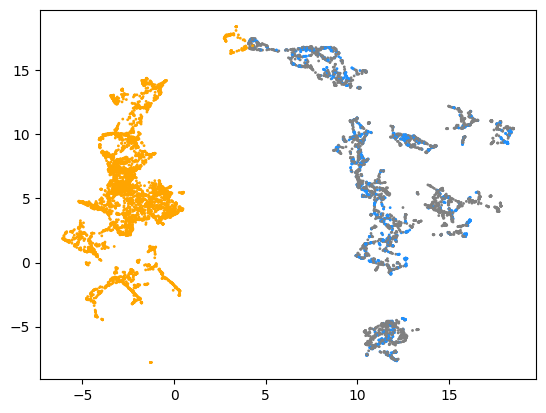

In [20]:
mol_colors = plt.colormaps['rainbow'](torch.randperm(len(mol_atom_class))/torch.randperm(len(mol_atom_class)).max())
classes = torch.tensor(mol_atom_class)

random_class_indices = torch.where(classes == torch.unique(classes)[torch.randperm(torch.unique(classes).size(0))][0])[0]

# RGB values normalized to the range [0, 1]
colors = [
    [0.5, 0.5, 0.5],      # Gray
    [30/255, 144/255, 255/255],  # Light Blue
    [1.0, 0.647, 0.0]      # Orange
]

# Convert list to a tensor
cols = torch.tensor(colors)

mol_atom_colors = cols[torch.zeros(classes.size(0)).long()]
# vox_colors = cols[torch.zeros(classes.size(0)).long()]

mol_atom_colors[random_class_indices] = cols[1]
# vox_colors[random_class_indices] = cols[2]
vox_colors = cols[2].repeat(torch.where(random_class_indices)[0].size(0), 1)


def project_data(data, color_tensor): 
    reducer = umap.UMAP(metric='cosine')
    scaled_data = StandardScaler().fit_transform(data)
    projection = reducer.fit_transform(scaled_data)
    plt.scatter(
        projection[:, 0],
        projection[:, 1],
        c=color_tensor,
        s=1)
    

N = 5000
mol_projection = project_data(torch.vstack((mol_atom_vals[:N],voxel_vals[random_class_indices])),
                              torch.vstack((mol_atom_colors[:N],vox_colors)))

tensor(10)